### This notebook wraps all the models from MNIST_Classification.ipynb. 

In particular, this runner gets a string of digit (0,1,2,3,4,5,6,7,8,9) as input, 

and it automatically evaluates some ML classification models in following steps:
    
- 1/ Read the data and assign features as X, label as y
- 2/ Train, test split: 0.3, 0.7
- 3/ Train and record training time of models including:
    * GradientBoostingClassifier
    * AdaBoostClassifier
    * RandomForestClassifier with gini index
    * RandomForestClassifier with entropy 
    * VotingClassifier of above all

- 3.1/ All the internel input parameters for each model are pre-determined with 5-fold gridsearch Cross Validation.

- 4/ Evaluates trained models by ROC and PR curves plotted.
- 5/ Calculate F1 score to pick the best model
- 6/ Display 4 misclassified images in the case of this best model

Here I only print out the the results for digit 9. Since it takes time to run all gridsearch procedures, I leave it for now. 

To use, just try to modify the input digit (string) and call ``run_all_models(digit)`` function. 

Environment Setup:

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

Import dataset:

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
pd.Series(mnist['target']).unique()

Model setup:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

import time

In [1]:
def run_all_models(dig: str):
    """
    This runner gets a string of digit (0,1,2,3,4,5,6,7,8,9) as input,
    evaluate some ML classification models in following steps:
    
    1/ Read the data and assign features as X, label as y
    2/ Train, test split: 0.3, 0.7
    3/ Train and record training time of models including:
        - GradientBoostingClassifier
        - AdaBoostClassifier
        - RandomForestClassifier with gini index
        - RandomForestClassifier with entropy 
        - VotingClassifier of above all

        All the internel input parameters for each model are 
        determined with 5-fold gridsearch Cross Validation.

    4/ Evaluates trained models by ROC and PR curves plotted.
    5/ Calculate F1 score to pick the best model
    6/ Display 4 misclassified images in the case of this best model

    """
    # 1/ Read the data and assign features as X, label as y
    print('========== Digit: %s ==========' % (dig))
    digit_store = []
    for i in mnist['target']:
        if i == dig:
            digit_store.append(1)
        else:
            digit_store.append(0)
    digit_store = np.array(digit_store)
    X, y = mnist['data'], digit_store


    # 2/ Train, test split: 0.3, 0.7
    print('Spliting data ...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.3, 
                                                        random_state=42)
    
    # 3/ Train and select optimal models including:
    # - GradientBoostingClassifier
    print('GBC starts ...')
    predictor = GradientBoostingClassifier(random_state=42)
    param_grid = [
        {
            'max_depth': [1, 3],
            'n_estimators':[5, 10],
            'learning_rate':[0.5]
        },
      ]
    start_time = time.time()
    grid_search = GridSearchCV(predictor, param_grid, cv=5,
                               scoring='neg_mean_squared_error', 
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    clf_gb_opt = grid_search.best_estimator_
    print("--- GBC %s seconds ---" % (time.time() - start_time))
    

    # - AdaBoostClassifier
    print('AdaBoost starts ...')
    DTC = DecisionTreeClassifier(random_state = 42)

    predictor = AdaBoostClassifier(base_estimator = DTC,
                                   random_state=42)
    param_grid = [
        {
            'base_estimator__criterion':["gini","entropy"],
            # 'base_estimator__splitter' :["best", "random"],
            # 'base_estimator__max_depth':[1,3,5]
            'n_estimators':[3, 100],
            'learning_rate':[0.5, 1.]
        },
      ]
    start_time = time.time()
    grid_search = GridSearchCV(predictor, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("--- AdaBoost %s seconds ---" % (time.time() - start_time))
    clf_ab_opt = grid_search.best_estimator_
    
    # - RandomForestClassifier with gini index
    print('RF1 starts ...')
    predictor = RandomForestClassifier(n_jobs=-1, 
                                       random_state=42, 
                                       criterion='gini')
    param_grid = [
        {
            'n_estimators':[50, 500],
            'max_leaf_nodes':[16, None]
        },
      ]
    start_time = time.time()
    grid_search = GridSearchCV(predictor, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("--- RF1 %s seconds ---" % (time.time() - start_time))
    clf_rf1_opt = grid_search.best_estimator_
    
    # - RandomForestClassifier with entropy 
    print('RF2 starts ...')
    predictor = RandomForestClassifier(n_jobs=-1, random_state=42, 
                                       criterion='entropy')
    param_grid = [
        {
            'n_estimators':[50, 500],
            'max_leaf_nodes':[16, None]
        },
      ]
    start_time = time.time()
    grid_search = GridSearchCV(predictor, param_grid, cv=5,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print("--- RF2 %s seconds ---" % (time.time() - start_time))
    clf_rf2_opt = grid_search.best_estimator_
    
    # - VotingClassifier of above all
    print('VC starts ...')
    voting_clf = VotingClassifier(
        estimators=[('GB', clf_gb_opt), ('AB', clf_ab_opt), 
                    ('RF1', clf_rf1_opt), ('RF2', clf_rf2_opt)],
        # voting approach: hard/soft
        voting='soft')
    voting_clf.fit(X_train, y_train)
    print('--- VC done. ---')
    

    # 4/ Evaluates trained models by ROC and PR curves plotted
    models = {'GradientBoosting': clf_gb_opt, 
              'AdaBoost': clf_ab_opt,
              'RF1': clf_rf1_opt,
              'RF2': clf_rf2_opt,
              'VC':voting_clf
             }    
    # ROC
    print('ROC starts ...')
    def plot_roc_curve(ax, fpr, tpr, label=None):
        ax.plot(fpr, tpr, linewidth=2, label=label)
        if label is not None:
            ax.legend()
        ax.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate (1-Specificity)', fontsize=16)
        plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)
        plt.title('ROC')
    for i, mname in enumerate(models.keys()):
        probs = models[mname].predict_proba(X_test)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_test, preds)
        if i == 0:
            fig, ax = plt.subplots(1,1, figsize=(8,8))
        plot_roc_curve(ax, fpr, tpr, label=mname)
    plt.show()
    
    # PR
    print('PR starts ...')
    def plot_pr_curve(ax, precision, recall, label=None):
        ax.plot(precision, recall, linewidth=2, label=label)
        if label is not None:
            ax.legend()
        ax.plot([0, 1], [0, 1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.title('PR')
    for i, mname in enumerate(models.keys()):
        probs = models[mname].predict_proba(X_test)
        preds = probs[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if i == 0:
            fig, ax = plt.subplots(1,1, figsize=(8,8))
        plot_pr_curve(ax, precision, recall, label=mname)
    plt.show()


    # 5/ Calculate F1 score to pick the best model
    print("Calculating F1 scores, getting best model, plot misclassified 4 images ...")
    f1_dig = {}
    y_true = y_test
    for mname in models.keys():
        y_pred = models[mname].predict(X_test)
        f1_dig[mname] = f1_score(y_true, y_pred)
    best_model = models[max(f1_dig, key=f1_dig.get)]
    y_pred = best_model.predict(X_test)
    y_true = y_test

    # 6/ Display 4 misclassified images in the case of this best model
    def plot_digit(data, label):
        pixels = np.array(data, dtype='uint8')
        image = pixels.reshape(28, 28)
        plt.imshow(image, cmap = matplotlib.cm.hot,
                   interpolation="nearest")
    count = 4
    for idx, (Xi, yi, yh) in enumerate(zip(X_test, y_true, y_pred)):
        if count == 0:
            break
        if yi != yh:
            plot_digit(Xi, label = 'image'+str(idx))
            plt.show()
            count-=1
    print('========== Done ==========')

========== Digit: 9 ==========
Spliting data ...
GBC starts ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.0min finished


--- GBC 241.3532886505127 seconds ---
AdaBoost starts ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.5min finished


--- AdaBoost 348.56536650657654 seconds ---
RF1 starts ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.9min finished


--- RF1 484.319287776947 seconds ---
RF2 starts ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.3min finished


--- RF2 511.63126134872437 seconds ---
VC starts ...
--- VC done. ---
ROC starts ...


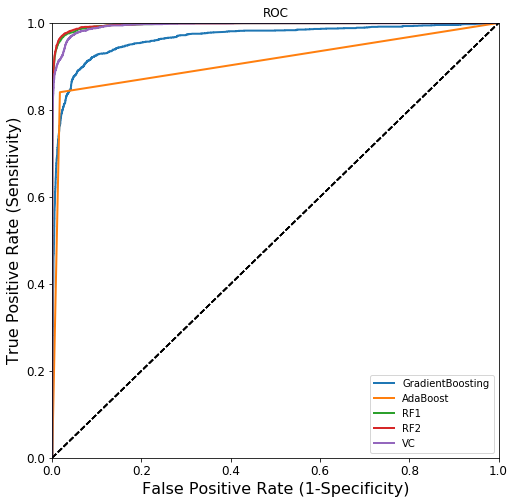

PR starts ...


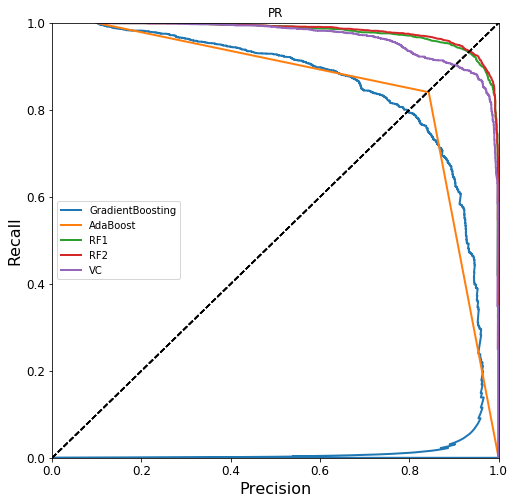

Calculating F1 scores, getting best model, plot misclassified 4 images ...


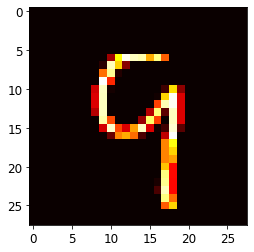

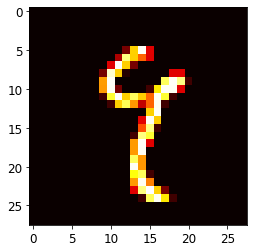

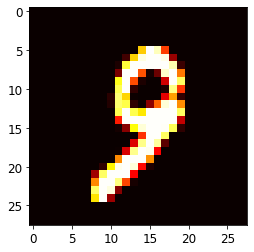

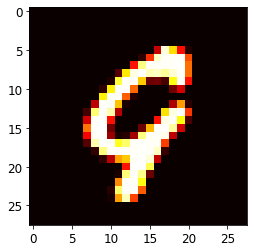

========== Done ==========


In [9]:
run_all_models('9')